In [957]:
import numpy as np
from ipywidgets import HBox, VBox, Label, Layout, Button
from IPython.display import display
from functools import partial
import random
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import math
from collections import defaultdict

In [789]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

## Константы

Определяем константы, "-1" у нас будет пустая клетка, "1" - крестик, "0" - нолик. Для удобства самообучаемых моделей введем обозначение хода, который может сделать модель - "2".

In [1278]:
EMPTY_CELL = -1
X_MARK = {'value': 1, 'visual': 'X'}
O_MARK = {'value': 0, 'visual': 'O'}
NEW_ACTION = 2

## Базовые классы

### View

Класс View предназначен для игры в Jupyter Notebook, симуляцию можно запускать и без него.

In [544]:
class View:
    def __init__(self, board=None, label='tic-tac-toe', turn_callback=None):
        self.board = board
        self.label = label
        self.turn_callback = turn_callback
    
    def on_click(self, row, column, button):
        self.turn_callback(row, column)
    
    def display(self):
        self.buttons = []
        buttons = []
        for r in range(3): # rows
            line = []
            for c in range(3): # columns
                button = Button(
                    description='',
                    layout=Layout(width='40px', height='40px')
                )
                
                button.on_click(partial(self.on_click, r, c))

                line.append(button)
                
            buttons.append(HBox(line))
            self.buttons.append(line)
        
        self.wlabel = Label(value=self.label)
        display(VBox([self.wlabel, VBox(buttons)]))
        
    def update(self, end_game):
        self.wlabel.value = self.label
        
        for r in range(3):
            for c in range(3):
                if self.board[r][c] == X_MARK['value']:
                    self.buttons[r][c].description = X_MARK['visual']
                    self.buttons[r][c].disabled = True
                elif self.board[r][c] == O_MARK['value']:
                    self.buttons[r][c].description = O_MARK['visual']
                    self.buttons[r][c].disabled = True
                elif end_game:
                    self.buttons[r][c].disabled = True

### RandomModel

Класс RandomModel представляет собой простейшую модель - игрока, который каждый раз ходит в произвольную свободную ячейку, никаких оценок хода не происходит. Анализа игры тоже нет.

Любая модель должна иметь три функции:
* make_turn(board, mark) - функция принимает состояние доски board и знак игрока mark. Функция возвращает кортеж из номера строки и столбца, куда модель производит ход.
* loss() - этой функцией управляющий класс сообщает модели, что модель проиграла
* win() - этой функцией управляющий класс сообщает модели, что модель выиграла

Последние две функции используются для обучения модели.

In [1367]:
class RandomModel:
    def __init__(self):
        pass
    
    def start(self):
        pass
    
    def make_turn(self, board, mark):
        if not np.isin(EMPTY_CELL, board):
            raise RuntimeError('No cell for turn')
            
        actions = []
        for r in range(3):
            for c in range(3):
                if board[r][c] == EMPTY_CELL:
                    actions.append((r, c))
                    
        return random.choice(actions)
    
    def loss(self):
        pass
    
    def win(self):
        pass
    
    def draw(self):
        pass

## HumanModel

Модель-заглушка, которая ничего не делает

In [1368]:
class HumanModel:
    def __init__(self):
        pass
    
    def start(self):
        pass
    
    def make_turn(self, board, mark):
        return None
    
    def loss(self):
        pass
    
    def win(self):
        pass
    
    def draw(self):
        pass    

### Game

Класс Game управляет игрой - проверяет ходы на соответствие правилам, передает ходы по очереди игрокам, определяет результат игры.

При инициализации класса в клас надо передать экземпляры классов модели, либо строку 'Human', если будет играть человек.

Также, необходимо передать экземпляр класса представления View, если мы хотим отобразить результаты игры.

In [1469]:
class Game:
    def __init__(self, board=None, player1=HumanModel(), player2=HumanModel(), view=None, play=True):
        if board is None:
            self.board = np.full((3,3), EMPTY_CELL)
        else:
            self.board = board
        
        self.player1 = {'mark': X_MARK, 'model': player1}
        self.player2 = {'mark': O_MARK, 'model': player2}
        self.current_player = self.player1
        
        self.winner = None
        self.draw = False
        self.end_game = False
        
        self.view = view
        if self.view is not None:
            self.view.board = self.board
            self.view.label = self.current_player['mark']['visual'] + "'s turn"
            self.view.turn_callback = self.process_turn
            self.view.display()
            
        self.player1['model'].start()
        self.player2['model'].start()
            
        if play:
            self.make_turn()
        
    def make_turn(self):
        action = self.current_player['model'].make_turn(self.board, self.current_player['mark']['value'])
        if action is None:
            return
        else:
            row, column = action
            self.process_turn(row, column)
        
    def end_check(self):
        """
        Returns True if there are no empty cells
        """
        if np.isin(EMPTY_CELL, self.board):
            return False
        else:
            return True
        
    def process_turn(self, row, column):
        if self.board[row][column] != EMPTY_CELL:
            raise RuntimeError('Cell already used')
        self.board[row][column] = self.current_player['mark']['value']
        
        # check for win after turn
        if self.win_check(self.current_player['mark']['value']):
            self.winner = self.current_player
            self.end_game = True
            
            # distribution of elephants
            if self.current_player == self.player1:
                self.player1['model'].win()
                self.player2['model'].loss()
            elif self.current_player == self.player2:
                self.player1['model'].loss()
                self.player2['model'].win()
                
        # check for draw
        elif self.end_check():
            self.draw = True
            self.winner = None
            self.end_game = True
            self.player1['model'].draw()
            self.player2['model'].draw()
        else:
            if self.current_player == self.player1:
                self.current_player = self.player2
            elif self.current_player == self.player2:
                self.current_player = self.player1
            else:
                raise RuntimeError('Unknown player')
        
        self.update_view()
        
        if not self.end_game:
            self.make_turn()
        
        
    def win_check(self, mark):
        lines = []
        lines.append([self.board[0][0], self.board[1][1], self.board[2][2]])
        lines.append([self.board[0][2], self.board[1][1], self.board[2][0]])
        
        for i in range(3):
            lines.append([self.board[0][i], self.board[1][i], self.board[2][i]])
            lines.append([self.board[i][0], self.board[i][1], self.board[i][2]])
        
        for l in lines:
            if l.count(mark) == 3:
                return True
        return False
    
    def update_view(self):
        if self.view is not None:
            if self.winner is not None:
                self.view.label = self.current_player['mark']['visual'] + ' wins!'
            elif self.draw:
                self.view.label = 'Draw!'
            else:
                self.view.label = self.current_player['mark']['visual'] + "'s turn"

            self.view.update(self.end_game)


## Собираем игру в единое целое

Если не указать модели - будут играть два человека

In [954]:
g = Game(view=View())

Между собой могуть играть модели

In [1310]:
g = Game(player1=RandomModel(), player2=RandomModel(), view=View())

Человек может играть за крестики...

In [946]:
g = Game(player2=RandomModel(), view=View())

...и за нолики

In [947]:
g = Game(player1=RandomModel(), view=View())

### Проведем пару экспериментов

Проведем множество игр между случайными моделями

In [948]:
x_wins = 0
o_wins = 0
draws = 0
x_wins_cum = []
o_wins_cum = []
draws_cum = []
for i in tqdm(range(2500)):
    g = Game(player1=RandomModel(), player2=RandomModel(), play=False)
    g.make_turn()
    if g.draw:
        draws += 1
    elif g.winner['mark'] == X_MARK:
        x_wins += 1
    elif g.winner['mark'] == O_MARK:
        o_wins += 1
    else:
        raise RuntimeError("Oops")
    
    x_wins_cum.append(x_wins)
    o_wins_cum.append(o_wins)
    draws_cum.append(draws)

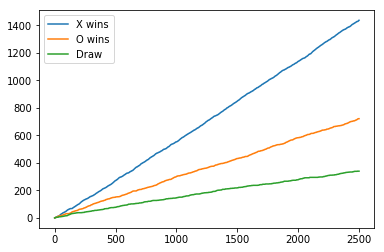

In [949]:
plt.plot(x_wins_cum, label='X wins')
plt.plot(o_wins_cum, label='O wins')
plt.plot(draws_cum, label='Draw')
plt.legend()
plt.show()

Как видно из графика, вероятность победить у крестика больше, чем у нолика

## Самообучающийся класс EvolutionModel

Попробуем создать простую самообучающуюся модель.

Перед ходом модель строит список всех возможных ходов, после чего сопоставляет этот список со списком доступных ходов и списком отвергнутых ходов. Отвергнутые ходы удалются, список доступных ходов пополняется.

При выигрыше модель для последнего хода оставляет в списке доступных ходов только выигрышный, а остальные отвергает.

При проигрыше модель последних ход отвергает. При этом, если в списке доступных ходов нет, то отвергает и предыдущий.

In [1377]:
class EvolutionModel():
    def __init__(self, storage=None):
        if storage is not None:
            self.storage = storage
        else:
            self.storage = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[]}
            
    def start(self):
        self.turns = []

    def get_decisions(self, board):
        turn_no = (board.reshape(9) != EMPTY_CELL).sum()

        for pos in self.storage[turn_no]:
            if self.is_similar_position(board, pos['current_position']):
                return pos
        
        pos = {
            'current_position': board.copy(),
            'available_actions': [],
            'negative_actions': []
        }
        self.storage[turn_no].append(pos)
        return pos
    
    def is_similar_position(self, pos1, pos2):
        for i in range(4):
            if np.array_equal(np.rot90(pos1, i), pos2):
                return True
            
        for i in range(4):
            if np.array_equal(np.rot90(np.flipud(pos1), i), pos2):
                return True
            
        return False
    
    def is_in_list(self, actions, position):
        for pos in actions:
            if self.is_similar_position(position, pos):
                return True
        return False
    
    def win(self):
        last_turn = self.turns[-1]
        des = self.get_decisions(last_turn['position'])
        actions = [x for x in des['available_actions'] if not self.is_similar_position(last_turn['turn'], x)]
        des['negative_actions'].extend(actions)
        des['available_actions'] = [last_turn['turn'].copy()]        
    
    def loss(self):
        for turn in reversed(self.turns):
            des = self.get_decisions(turn['position'])
            des['negative_actions'].append(turn['turn'])
            des['available_actions'] = [x for x in des['available_actions'] if not self.is_similar_position(turn['turn'], x)]
            if len(des['available_actions']) > 0:
                break
                
    def draw(self, board):
        pass
    
    def make_turn(self, board, mark):
        # raise error, if we have no free cells
        if not np.isin(-1, board):
            raise RuntimeError('No cell for turn')
            
        # get good and bad actions for current position
        decision = self.get_decisions(board)
            
        # get all possible actions
        all_actions = []
        for r in range(3):
            for c in range(3):
                if board[r][c] == EMPTY_CELL:
                    all_actions.append((r, c))
                    
        # check all actions for consequences
        actions = []
        for r, c in all_actions:
            action = board.copy()
            action[r][c] = mark
            
            # if it is bad action - refuse it
            if self.is_in_list(decision['negative_actions'], action):
                continue
                
            # if it is good action - save it
            if self.is_in_list(decision['available_actions'], action):
                actions.append((r, c))
                continue
                
            # add action
            decision['available_actions'].append(action)
            actions.append((r, c))
            
        if len(actions) > 0:
            turn_coords = random.choice(actions)
        else:
            # all actions are negative, but we need to play
            # and we need to negate previous turn
            self.loss()
            turn_coords = random.choice(all_actions)
        
        # store turn
        r, c = turn_coords
        turn = board.copy()
        turn[r][c] = mark
        self.turns.append({'position': board.copy(), 'turn': turn})
        
        return turn_coords

### Проведем испытания модели

Для обоих игроков будем использовать одно и тоже хранилище данных. Если для каждой модели использовать отдельное хранилище, то в одном будут заполнены только четные ходы, а в другом - только нечетные

In [1374]:
evo_storage = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[]}

Модель успешно играет сама с собой

In [1375]:
g = Game(player1=EvolutionModel(storage=evo_storage), player2=EvolutionModel(storage=evo_storage), view=View())

Попросим модель поиграть саму с собой много раз

In [1378]:
evo_storage = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[]}
negative_actions = []
available_actions = []
x_wins = 0
o_wins = 0
draws = 0
x_wins_cum = []
o_wins_cum = []
draws_cum = []
#games = []
for i in tqdm(range(2500)):
    g = Game(player1=EvolutionModel(storage=evo_storage), player2=EvolutionModel(storage=evo_storage), play=False)
    #games.append(g)
    g.make_turn()
    if g.draw:
        draws += 1
    elif g.winner['mark'] == X_MARK:
        x_wins += 1
    elif g.winner['mark'] == O_MARK:
        o_wins += 1
    else:
        raise RuntimeError("Oops")
    
    neg_act = 0
    av_act = 0
    for t in evo_storage.values():
        for d in t:
            neg_act += len(d['negative_actions'])
            av_act += len(d['available_actions'])
    
    negative_actions.append(neg_act)
    available_actions.append(av_act)
    x_wins_cum.append(x_wins)
    o_wins_cum.append(o_wins)
    draws_cum.append(draws)

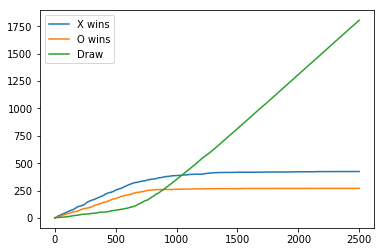

In [1379]:
plt.plot(x_wins_cum, label='X wins')
plt.plot(o_wins_cum, label='O wins')
plt.plot(draws_cum, label='Draw')
plt.legend()
plt.show()

Примерно после 1000 игр модель хорошо обучилась и игры оканчиваются ничьей, что свидетельствует о правильной игре обоих сторон.

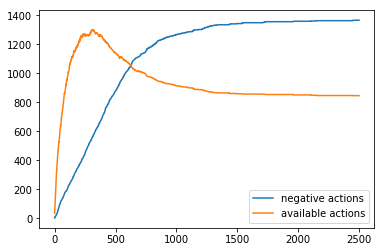

In [1380]:
plt.plot(negative_actions, label='negative actions')
plt.plot(available_actions, label='available actions')
plt.legend()
plt.show()

График показывает количество возможных ходов и отвернутых ходов после каждой игры. Как видно из графика, обучение продолжается и после двух тысяч игр.

In [840]:
#save_obj(evo_storage, 'evomodel')

In [841]:
#evo_storage = load_obj('evomodel')

Попробуем свести обученную модель и случайную модель

In [842]:
#evo_storage = load_obj('evomodel')
negative_actions = []
available_actions = []
x_wins = 0
o_wins = 0
draws = 0
x_wins_cum = []
o_wins_cum = []
draws_cum = []
#games = []
for i in tqdm(range(2500)):
    g = Game(player1=RandomModel(), player2=EvolutionModel(storage=evo_storage), play=False)
    #games.append(g)
    g.make_turn()
    if g.draw:
        draws += 1
    elif g.winner['mark'] == X_MARK:
        x_wins += 1
    elif g.winner['mark'] == O_MARK:
        o_wins += 1
    else:
        raise RuntimeError("Oops")
    
    neg_act = 0
    av_act = 0
    for t in evo_storage.values():
        for d in t:
            neg_act += len(d['negative_actions'])
            av_act += len(d['available_actions'])
    
    negative_actions.append(neg_act)
    available_actions.append(av_act)
    x_wins_cum.append(x_wins)
    o_wins_cum.append(o_wins)
    draws_cum.append(draws)

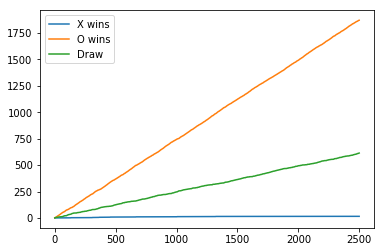

In [843]:
plt.plot(x_wins_cum, label='X wins')
plt.plot(o_wins_cum, label='O wins')
plt.plot(draws_cum, label='Draw')
plt.legend()
plt.show()

Как и ожидалось - обученная модель уверенно выигрывает у случайной модели, но не всегда.

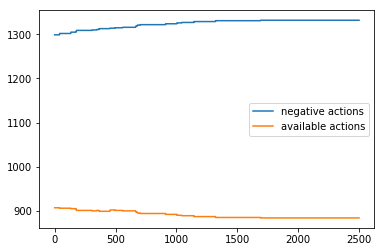

In [844]:
plt.plot(negative_actions, label='negative actions')
plt.plot(available_actions, label='available actions')
plt.legend()
plt.show()

Как видно из графика, модель может еще немного дообучиться у случайного игрока

Дообучим модель за крестики - теперь случайный игрок будет играть за нолики

In [845]:
negative_actions = []
available_actions = []
x_wins = 0
o_wins = 0
draws = 0
x_wins_cum = []
o_wins_cum = []
draws_cum = []
#games = []
for i in tqdm(range(2500)):
    g = Game(player1=EvolutionModel(storage=evo_storage), player2=RandomModel(), play=False)
    #games.append(g)
    g.make_turn()
    if g.draw:
        draws += 1
    elif g.winner['mark'] == X_MARK:
        x_wins += 1
    elif g.winner['mark'] == O_MARK:
        o_wins += 1
    else:
        raise RuntimeError("Oops")
    
    neg_act = 0
    av_act = 0
    for t in evo_storage.values():
        for d in t:
            neg_act += len(d['negative_actions'])
            av_act += len(d['available_actions'])
    
    negative_actions.append(neg_act)
    available_actions.append(av_act)
    x_wins_cum.append(x_wins)
    o_wins_cum.append(o_wins)
    draws_cum.append(draws)

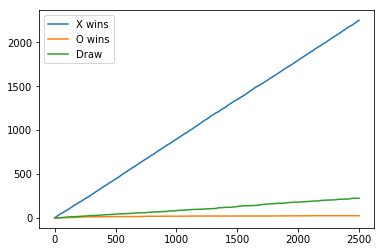

In [846]:
plt.plot(x_wins_cum, label='X wins')
plt.plot(o_wins_cum, label='O wins')
plt.plot(draws_cum, label='Draw')
plt.legend()
plt.show()

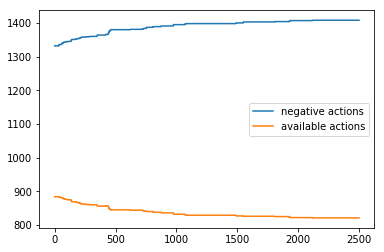

In [847]:
plt.plot(negative_actions, label='negative actions')
plt.plot(available_actions, label='available actions')
plt.legend()
plt.show()

Результат дообучения аналогичен.

Итого мы обучили модель на 7500 играх. По результатам игры у нас было отвергнуто ~1400 возможных ходов и осталось чуть больше 800, и за крестики и за нолики.

In [814]:
#save_obj(evo_storage, 'evomodel_plus_rnd')

## MinimaxModel

Модель, которая выбирает следющий ход на основе рекурсивного алгоритма minimax. Модель всегда делает правильные ходы - обыграть ее невозможно.

In [1329]:
class MinimaxModel:
    def __init__(self):
        pass
    
    def start(self):
        pass
    
    def win(self, board):
        pass
    
    def loss(self, board):
        pass
    
    def draw(self, board):
        pass
    
    def make_turn(self, board, mark):
        # raise error, if we have no free cells
        if not np.isin(-1, board):
            raise RuntimeError('No cell for turn')
            
        self.my_mark = mark
        
        scored_action = self.minimax(board, mark)
        return scored_action['action']
    
    def minimax(self, board, mark):
        # get all possible actions
        actions = []
        for r in range(3):
            for c in range(3):
                if board[r][c] == EMPTY_CELL:
                    actions.append((r, c))
                    
        if self.win_check(board, self.my_mark):
            return {'score': 1, 'action': None}
        elif self.win_check(board, self.next_mark(self.my_mark)):
            return {'score': -1, 'action': None}
        elif len(actions) == 0:
            return {'score': 0, 'action': None}
        
        scored_actions = [None]*len(actions)
        for idx, itm in enumerate(actions):
            #next_board = board.copy()
            board[itm[0]][itm[1]] = mark
            score = self.minimax(board, self.next_mark(mark))['score']
            scored_actions[idx] = {'score': score, 'action': itm}
            board[itm[0]][itm[1]] = EMPTY_CELL
            
        action = {'score': 0, 'action': None}
        if self.my_mark == mark:
            action['score'] = -math.inf
            for sa in scored_actions:
                if sa['score'] > action['score']:
                    action = sa
        elif self.my_mark == self.next_mark(mark):
            action['score'] = math.inf
            for sa in scored_actions:
                if sa['score'] < action['score']:
                    action = sa
        else:
            raise RuntimeError('Unknown mark: ' + str(mark))
            
        return action
        
    def win_check(self, board, mark):
        if ((board[0][0] == mark and board[1][1] == mark and board[2][2] == mark) or
            (board[0][2] == mark and board[1][1] == mark and board[2][0] == mark) or
            (board[0][0] == mark and board[1][0] == mark and board[2][0] == mark) or
            (board[0][1] == mark and board[1][1] == mark and board[2][1] == mark) or
            (board[0][2] == mark and board[1][2] == mark and board[2][2] == mark) or
            (board[0][0] == mark and board[0][1] == mark and board[0][2] == mark) or
            (board[1][0] == mark and board[1][1] == mark and board[1][2] == mark) or
            (board[2][0] == mark and board[2][1] == mark and board[2][2] == mark)):
            return True
        else:
            return False
    
    def next_mark(self, mark):
        if mark == 1:
            return 0
        elif mark == 0:
            return 1
        else:
            raise RuntimeError('Unknown mark: ' + str(mark))


Логичный результат игры модели самой против себя - ничья

In [1323]:
g = Game(player1=MinimaxModel(), player2=MinimaxModel(), view=View())

Как выяснилось, алгоритм minimax работает долго, особенно для первых ходов игры - ведь он строит все возможные варианты игры на каждом ходу.

### Поэксперементируем с MinimaxModel

In [911]:
m = MinimaxModel()
x_wins = 0
o_wins = 0
draws = 0
x_wins_cum = []
o_wins_cum = []
draws_cum = []
for i in tqdm(range(10)):
    g = Game(player1=m, player2=m, play=False)
    g.make_turn()
    if g.draw:
        draws += 1
    elif g.winner['mark'] == X_MARK:
        x_wins += 1
    elif g.winner['mark'] == O_MARK:
        o_wins += 1
    else:
        raise RuntimeError("Oops")
    
    x_wins_cum.append(x_wins)
    o_wins_cum.append(o_wins)
    draws_cum.append(draws)

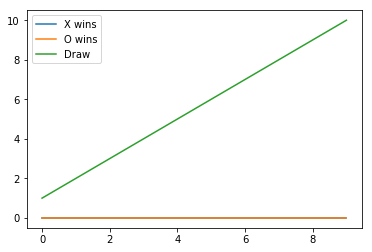

In [912]:
plt.plot(x_wins_cum, label='X wins')
plt.plot(o_wins_cum, label='O wins')
plt.plot(draws_cum, label='Draw')
plt.legend()
plt.show()

Результат ожидаем - ни одного выигрыша, только ничьи

Попробуем обучить модель EvolutionModel с помощью метода minimax.

In [933]:
evo_storage = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[]}
negative_actions = []
available_actions = []
x_wins = 0
o_wins = 0
draws = 0
x_wins_cum = []
o_wins_cum = []
draws_cum = []
g = None
for i in tqdm(range(2500)):
    g = Game(player1=EvolutionModel(storage=evo_storage), player2=MinimaxModel(), play=False)
    g.make_turn()
    if g.draw:
        draws += 1
    elif g.winner['mark'] == X_MARK:
        x_wins += 1
    elif g.winner['mark'] == O_MARK:
        o_wins += 1
    else:
        raise RuntimeError("Oops")
    
    neg_act = 0
    av_act = 0
    for t in evo_storage.values():
        for d in t:
            neg_act += len(d['negative_actions'])
            av_act += len(d['available_actions'])
    
    negative_actions.append(neg_act)
    available_actions.append(av_act)
    x_wins_cum.append(x_wins)
    o_wins_cum.append(o_wins)
    draws_cum.append(draws)

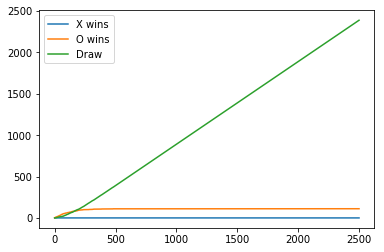

In [934]:
plt.plot(x_wins_cum, label='X wins')
plt.plot(o_wins_cum, label='O wins')
plt.plot(draws_cum, label='Draw')
plt.legend()
plt.show()

Как видно, модели EvolutionModel ни разу не удалось выиграть, что было ожидаемо.

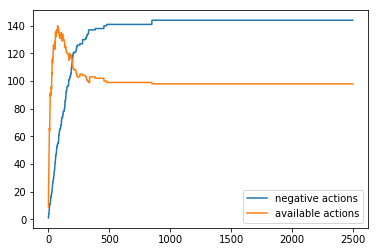

In [935]:
plt.plot(negative_actions, label='negative actions')
plt.plot(available_actions, label='available actions')
plt.legend()
plt.show()

Обучаем другую сторону модели EvolutionModel

In [936]:
g = None
for i in tqdm(range(2500)):
    g = Game(player1=MinimaxModel(), player2=EvolutionModel(storage=evo_storage), play=False)
    g.make_turn()
    if g.draw:
        draws += 1
    elif g.winner['mark'] == X_MARK:
        x_wins += 1
    elif g.winner['mark'] == O_MARK:
        o_wins += 1
    else:
        raise RuntimeError("Oops")
    
    neg_act = 0
    av_act = 0
    for t in evo_storage.values():
        for d in t:
            neg_act += len(d['negative_actions'])
            av_act += len(d['available_actions'])
    
    negative_actions.append(neg_act)
    available_actions.append(av_act)
    x_wins_cum.append(x_wins)
    o_wins_cum.append(o_wins)
    draws_cum.append(draws)

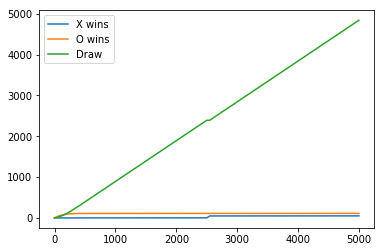

In [937]:
plt.plot(x_wins_cum, label='X wins')
plt.plot(o_wins_cum, label='O wins')
plt.plot(draws_cum, label='Draw')
plt.legend()
plt.show()

Ступенька на графике обусловлена сменой стороны - был достроен график с предыдущего эксперимента

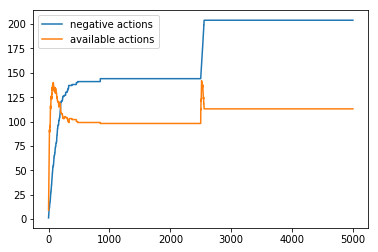

In [938]:
plt.plot(negative_actions, label='negative actions')
plt.plot(available_actions, label='available actions')
plt.legend()
plt.show()

Судя по графику, модель обучается до стабильной ничьей примерно за 1000 игр. Но, что мы имеем в итоге - доступных ходов около 115, отвергнутых ходов - около 200. Сравнивая с предыдущими попытками обучения, можно сказать, что здесь обучение вышло однобоким и неполным.

In [1586]:
class QLearnModel:
    def __init__(self, alpha, gamma, exploration, exploration_decay, Q_table=None):
        self.alpha = alpha
        self.gamma = gamma
        self.exploration = exploration
        self.exploration_decay = exploration_decay
        if Q_table is not None:
            self.Q_table = Q_table
        else:
            self.Q_table = dict

    def start(self):
        self.states = []
        self.actions = []
    
    
    def get_actions_for_state(self, board):
        # get all possible actions
        all_actions = []
        for r in range(3):
            for c in range(3):
                if board[r][c] == EMPTY_CELL:
                    all_actions.append((r, c))
        
        return all_actions
    
    def make_turn(self, board, mark):
        
        all_actions = self.get_actions_for_state(board)
                    
        if self.exploration > random.random():
            # exploration
            action = random.choice(all_actions)
        else:
            # exploitation
            weighted_actions = {}
            
            Q_state = tuple(board.reshape(9))

            #get weights of actions
            for action in all_actions:
                weighted_actions[action] = self.get_Q_table_element_value(Q_state, action)
                
            #get max weight(s)
            max_weight = max([x for x in weighted_actions.values() if x is not None])
            max_actions = [x for x in weighted_actions if weighted_actions[x] == max_weight]
            
            action = random.choice(max_actions)

        self.exploration *= (1.0 - self.exploration_decay)
        
        self.update_model(board, action)
        
        return action
    
    def update_model(self, state, action):
        self.states.append(state.copy())
        self.actions.append(action)
        
        if len(self.states) > 1:
            prev_state = self.states[-2]
            prev_action = self.actions[-2]
            
            Q_state = tuple(state.reshape(9))
            Q_prev_state = tuple(prev_state.reshape(9))
            
            # для отладки
            self.Q_state = Q_state
            self.Q_prev_state = Q_prev_state
            self.action = action
            self.prev_action = prev_action
            
            # reward=0 - оценить хорошесть хода мы можем только по окончании игры
            self.temporal_difference_learning(0, Q_prev_state, prev_action, Q_state)
    
    def loss(self):
        Q_state = tuple(self.states[-1].reshape(9))
        action = self.actions[-1]
        self.monte_carlo_approach(-1, Q_state, action)
    
    def win(self):
        Q_state = tuple(self.states[-1].reshape(9))
        action = self.actions[-1]
        self.monte_carlo_approach(1, Q_state, action)
        
    def draw(self):
        Q_state = tuple(self.states[-1].reshape(9))
        action = self.actions[-1]
        self.monte_carlo_approach(0, Q_state, action)
        
    def temporal_difference_learning(self, reward, Q_prev_state, prev_action, Q_state):
        prev_value = self.get_Q_table_element_value(Q_prev_state, prev_action)
        values = self.get_Q_table_state(Q_state).values()
        max_value = max(values) if len(values) > 0 else 0
        self.Q_table[Q_prev_state][prev_action] += self.alpha * (reward + self.gamma * max_value - prev_value)
        
    def monte_carlo_approach(self, reward, Q_state, action):
        val = self.get_Q_table_element_value(Q_state, action)
        self.Q_table[Q_state][action] += self.alpha * (reward - val)
        
    def get_Q_table_state(self, Q_state):
        if Q_state not in self.Q_table:
            self.Q_table[Q_state] = {}
        return self.Q_table[Q_state]
    
    def get_Q_table_element_value(self, Q_state, action):
        actions = self.get_Q_table_state(Q_state)
        if action not in actions:
            actions[action] = 0
            
        return actions[action]    

In [1587]:
Q_table = dict()

In [1588]:
qm1 = QLearnModel(alpha=0.5, gamma=0.9, exploration=0.1, exploration_decay=0, Q_table=Q_table)
qm2 = QLearnModel(alpha=0.5, gamma=0.9, exploration=0.1, exploration_decay=0, Q_table=Q_table)

In [1589]:
g = Game(player1=qm1, player2=qm2, view=View())

In [1580]:
Q_table

{}

In [1553]:
Q_table = dict()
q = QLearnModel(0.5, 0.9, 0, 0, Q_table)
q.start()

In [1554]:
b0 = np.full((3,3), EMPTY_CELL)
b0

array([[-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1]])

In [1555]:
q.make_turn(b0, None)

1
1
1
1
1
1
1
1


(1, 2)

In [1548]:
b1 = b0.copy()
b1[2][0] = 1
b1

array([[-1, -1, -1],
       [-1, -1, -1],
       [ 1, -1, -1]])

In [1549]:
tuple(b1.reshape(9))

(-1, -1, -1, -1, -1, -1, 1, -1, -1)

In [1557]:
q.find_state(tuple(b1.reshape(9)))

((-1, -1, -1, -1, -1, -1, -1, -1, -1), (True, False, 0))

In [ ]:
Q_state = tuple(b1.reshape(9))
if Q_state in Q_table:
    #return (Q_state, (True, False, 0))
    print('1')

for state in Q_table:
    is_sim = is_similar_position(np.array(state).reshape(3, 3), board)
    if is_sim[0]:
        #return (state, is_sim)

self.Q_table[Q_state] = {}
return (Q_state, (True, False, 0))


In [1592]:
Q_table = {}
negative_actions = []
available_actions = []
x_wins = 0
o_wins = 0
draws = 0
x_wins_cum = []
o_wins_cum = []
draws_cum = []
#games = []
for i in tqdm(range(10000)):
    g = Game(player1=QLearnModel(0.5, 0.9, 0.1, 0.1, Q_table), player2=QLearnModel(0.5, 0.9, 0.1, 0.1, Q_table), play=False)
    #games.append(g)
    g.make_turn()
    if g.draw:
        draws += 1
    elif g.winner['mark'] == X_MARK:
        x_wins += 1
    elif g.winner['mark'] == O_MARK:
        o_wins += 1
    else:
        raise RuntimeError("Oops")
    
    neg_act = 0
    av_act = 0
    for t in evo_storage.values():
        for d in t:
            neg_act += len(d['negative_actions'])
            av_act += len(d['available_actions'])
    
    negative_actions.append(neg_act)
    available_actions.append(av_act)
    x_wins_cum.append(x_wins)
    o_wins_cum.append(o_wins)
    draws_cum.append(draws)

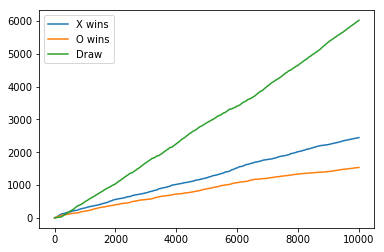

In [1593]:
plt.plot(x_wins_cum, label='X wins')
plt.plot(o_wins_cum, label='O wins')
plt.plot(draws_cum, label='Draw')
plt.legend()
plt.show()

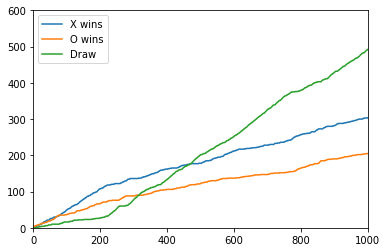

In [1602]:
plt.plot(x_wins_cum, label='X wins')
plt.plot(o_wins_cum, label='O wins')
plt.plot(draws_cum, label='Draw')
plt.xlim(0, 1000)
plt.ylim(0, 600)
plt.legend()
plt.show()

TODO:

* вынести модели в отдельные файлы (%load)
* убрать из эволюционной модели излишнюю обучаемость
* отрефактарить на статическую типизацию
* переделать тестовые прогоны - каждому прогону свой набор переменных
* переделать графики - увеличить интересные места
* отрефакторить модели на иерархию классов.
* ускорить минимакс - можно захаркодить первые два хода
* добавить в минимакс глубину решения
* добавить комментов